In [71]:
%load_ext autoreload
%autoreload 2
from utils import load_model, get_mask
import sys
import os
from argparse import Namespace

from dataset.datasets import *
from dataset.utils import get_dataloader
from evaluation.utils import *

import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use('science')
sns.set_style('whitegrid')
sns.set_palette('Dark2')

plt.rcParams['text.latex.preamble'] = "\\usepackage{lmodern} \\usepackage{times} \\usepackage{amssymb}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# Load the models
save_dirs = {
    'NP' : '../saves/inp_sinusoids/np_0',
    'INP' : '../saves/inp_sinusoids/inp_abc2_1_0'
}

models = list(save_dirs.keys())
model_dict = {}
config_dict = {}

for model_name, save_dir in save_dirs.items():
    model_dict[model_name], config_dict[model_name] = load_model(save_dir, load_it='best')
    model_dict[model_name].eval()

model_names = list(model_dict.keys())

../saves/inp_sinusoids/np_0
../saves/inp_sinusoids/inp_abc2_1_0
../saves/inp_sinusoids/inp_abc2_2_0
../saves/inp_sinusoids/inp_abc2_3_0
../saves/inp_sinusoids/inp_abc2_4_0
../saves/inp_sinusoids/inp_abc2_5_0


In [92]:
# Setup the dataloaders
config = Namespace(
      min_num_context=0,
      max_num_context=100,
      num_targets=100,
      noise=0.2,
      batch_size=32,
      x_sampler='uniform',
      test_num_z_samples=32,
      dataset='set-trending-sinusoids',
      device='cuda:0'
  )

dataset = SetKnowledgeTrendingSinusoids(
  root='../data/trending-sinusoids', split='test', knowledge_type='full'
)
data_loader = get_dataloader(dataset, config)

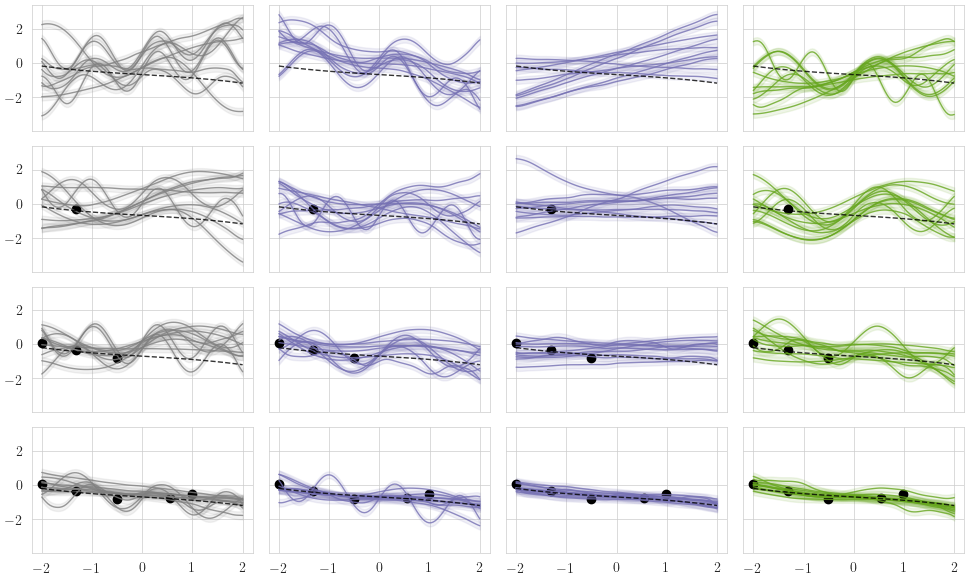

In [83]:
# Plot sample predictions

for batch in data_loader:
    (x_context, y_context), (x_target, y_target), full_knowledge, extras = batch
    x_context = x_context.to(config.device)
    y_context = y_context.to(config.device)
    x_target = x_target.to(config.device)
    y_target = y_target.to(config.device)


num_context_ls = [0, 1, 3, 5]
sample_idx = np.random.choice(list(range(x_target.shape[-2])), max(num_context_ls))
batch_idx = 0

fig, axs = plt.subplots(len(num_context_ls), 4, figsize=(10, 6), sharex=True, sharey=True)

colors = {
    'raw' : 'grey',
    'a' : 'C2',
    'b' : 'C2',
    'c' : 'C4'
}

for j, knowledge_type in enumerate(['raw', 'a', 'b', 'c']):
    if knowledge_type == 'raw':
        knowledge = None
    else:
        mask = get_mask(knowledge_type)
        knowledge = full_knowledge * mask
    
    for i, num_context in enumerate(num_context_ls):
        x_context = x_target[:, sample_idx[:num_context], :]
        y_context = y_target[:, sample_idx[:num_context], :]

        with torch.no_grad():
            INP_outupts = model_dict['INP'](
                x_context, y_context, x_target, y_target=y_target, knowledge=knowledge)

        plot_predictions(
            axs[i][j], batch_idx, INP_outupts, x_context, y_context, x_target, extras, color=colors[knowledge_type], plot_true=True
        )
plt.tight_layout()
plt.show()

In [93]:
# Evaluate the models on different knowledge types
eval_type_ls = ['raw', 'informed', 'a', 'b', 'c', 'ab', 'bc', 'ac']

summary_df, losses, outputs_dict = get_summary_df(model_dict, config_dict, data_loader, eval_type_ls, model_names)

summary_df['print_value'] = summary_df['mean'].apply(lambda x: f'{x:.1f}') #+ ' \scriptsize{(' + summary_df['std'].apply(lambda x: f'{x:.1f}') + ')}'
print_df = summary_df.dropna(subset=['mean']).pivot(
    columns='num_context', index=['model_name', 'eval_type'], values=['print_value']
).T.round(2)

print_df.droplevel(0, axis=0).dropna(axis=1, how='all')

model_name   INP_1                                                  INP_2  \
eval_type        a    ab     ac     b    bc      c informed    raw      a   
num_context                                                                 
0            211.9  57.7  133.4  94.3  66.5  246.2     38.9  294.6  201.5   
1            176.2  46.5  157.7  61.6  54.6  198.1     41.5  233.0  157.9   
3            105.6  17.7   85.6  20.5  17.5  108.1     15.3  130.6   76.6   
5             54.1   7.6   48.8   9.8   8.4   56.4      6.1   63.1   40.4   
10            19.4  -2.2   14.5  -2.1  -2.5   17.8     -2.3   20.0   18.1   
15             6.5  -6.3    4.3  -6.2  -6.7    5.9     -6.6    8.3    3.8   

model_name         ...  INP_4  INP_5                                           \
eval_type      ab  ...    raw      a    ab     ac     b    bc      c informed   
num_context        ...                                                          
0            52.5  ...  326.0  205.1  60.6  179.9  81.8  68.6  243.5     50.9   
1            50.8  ...  211.1  176.3  62.5  152.3  75.6  63.5  177.1     54.8   
3            17.5  ...   90.2   97.1  28.3   83.5  38.7  30.3  100.8     24.4   
5             2.7  ...   51.6   57.3  11.2   50.4  12.9  10.6   58.9      9.2   
10           -4.6  ...   22.5   23.0  -1.2   20.1  -0.5  -1.0   24.9     -1.2   
15           -7.3  ...   10.2   11.5  -3.9    9.9  -3.7  -3.8   12.8     -4.6   

model_name             NP  
eval_type      raw    raw  
num_context                
0            300.1  304.5  
1            201.0  226.8  
3            117.1  106.7  
5             64.2   61.1  
10            25.5   20.1  
15            13.1    8.8  

[6 rows x 41 columns]

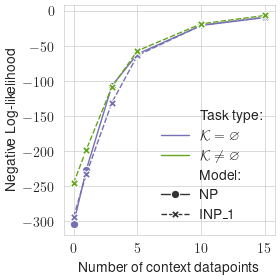

In [104]:
plot_df = summary_df[
    (summary_df.model_name.isin(['INP', 'NP'])) & 
    (summary_df.eval_type.isin(['raw', 'informed']))
].copy().reset_index(drop=True)
plot_df['mean'] = -plot_df['mean']
plot_df['eval_type'] = plot_df['eval_type'].map({
    'raw': r'$\mathcal{K} = \varnothing$',
    'informed': r'$\mathcal{K} \neq \varnothing$'
})


fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(
    plot_df, 
    x='num_context', y='mean', 
    hue='eval_type', style='model_name', 
    palette=['C2', 'C4'], ax=ax,
    style_order=['NP', 'INP_1'], markers=True
)

ax.set_ylabel('Negative Log-likelihood')
ax.set_xlabel('Number of context datapoints')

handles, labels = ax.get_legend_handles_labels()

labels[0] = 'Task type:'
labels[3] = 'Model:'

plt.legend(labels=labels, handles=handles)
plt.tight_layout()
plt.savefig('../figures/exp-1.pdf')
plt.show()

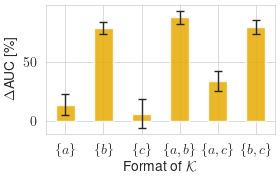

In [100]:
# Delta-AUC 
model_name = 'INP'

eval_type_ls = ['a', 'b', 'c', 'ab', 'ac', 'bc']
num_context_ls = [0, 1, 3, 5, 10, 15]

auc_summary = get_auc_summary(losses, model_name, eval_type_ls, num_context_ls)

auc_df = (pd.DataFrame(auc_summary).T * 100).round(1)
auc_df.columns = ['mean', 'se']
# plot bar chart with error bars
fig, ax = plt.subplots(figsize=(3, 2))
auc_df['mean'].plot.bar(yerr=auc_df['se'], ax=ax, capsize=3, color='C5', alpha=0.85)
ax.set_ylabel('$\Delta$AUC [\%]')
ax.set_xlabel('Format of $\mathcal{K}$')
ax.set_xticklabels(['$\\{%s\\}$' %', '.join(list(k)) for k in auc_df.index], rotation=0)
plt.tight_layout()
plt.savefig('../figures/sinusoid_auc.pdf', bbox_inches='tight')
plt.show()

In [78]:
from tqdm import tqdm

knowledge_type_ls = ['raw', 'informed', 'a', 'b', 'c']
num_context_ls = [0, 1]

uncertainties = get_uncertainties(outputs_dict, num_context_ls, knowledge_type_ls, model_name='INP', n_batches=30)

num_context: 0 eval_type: raw


NameError: name 'tqdm' is not defined

tensor([[0.2222]])


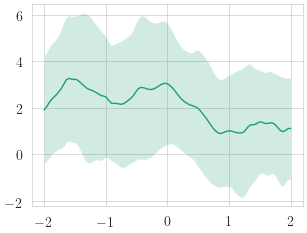

In [ ]:
batch_idx = 12
uncert_type = 'epistemic'

x_target = np.linspace(-2, 2, 100)
fig, ax = plt.subplots()
uncertainty_reduction = uncertainties[0]['raw'][batch_idx][uncert_type] - uncertainties[1]['raw'][batch_idx][uncert_type]
mean_reduction = uncertainty_reduction.mean(axis=0)
std = (uncertainty_reduction).std(axis=0)
print(outputs_dict['INP']['raw'][1][batch_idx]['x_context'][0])
ax.plot(x_target, mean_reduction)
ax.fill_between(
    x_target,
    mean_reduction - std,
    mean_reduction + std,
    alpha=0.2
)
ax.set_xticks([-2, -1, 0, 1, 2])
#ax.set_xticklabels(['$24^{00}$', '$06^{00}$', '$12^{00}$', '$18^{00}$', '$24^{00}$'])
plt.show()

/tmp/ipykernel_249022/1492847492.py:50: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in axs[i][1].legend(handlelength=0, handletextpad=0, loc='lower right', frameon=True).legendHandles:


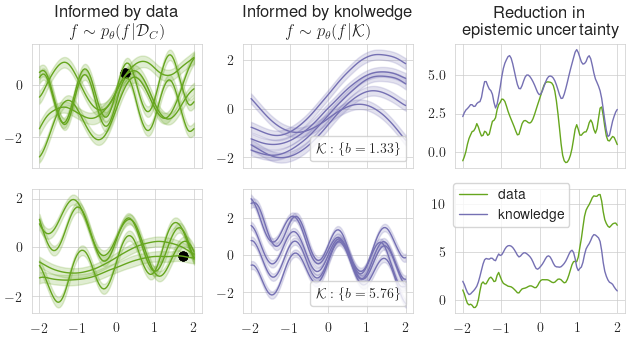

In [ ]:
num_context = 1
idx_ls =  [('b', 12, 2)] + [('b', 6, 7)] 

fig, axs = plt.subplots(len(idx_ls), 3, figsize=(6.5, 1.8 * len(idx_ls)), sharex=True)

model_name = 'INP'
uncert_type = 'epistemic'

for i, (knowledge_type, batch_idx, in_batch_idx) in enumerate(idx_ls):

    uncert_reduction_knowledge = (uncertainties[0]['raw'][batch_idx][uncert_type] - uncertainties[0][knowledge_type][batch_idx][uncert_type])
    uncert_reduction_data = (uncertainties[0]['raw'][batch_idx][uncert_type] - uncertainties[num_context]['raw'][batch_idx][uncert_type])

    for sample_id in [0, 1, 3, 5, 7]:#range(5):
        eval_type = 'raw'
        mu = outputs_dict[model_name][eval_type][num_context][batch_idx]['outputs'][0].mean[:, :, :].cpu()
        sigma = outputs_dict[model_name][eval_type][num_context][batch_idx]['outputs'][0].stddev[:, :, :].cpu()
        x_context = outputs_dict[model_name][eval_type][num_context][batch_idx]['x_context']
        y_context = outputs_dict[model_name][eval_type][num_context][batch_idx]['y_context']
        x_target = outputs_dict[model_name][eval_type][num_context][batch_idx]['x_target']
        y_target = outputs_dict[model_name][eval_type][num_context][batch_idx]['y_target']
        #axs[i][0].plot(x_target[in_batch_idx, :].flatten(), y_target[in_batch_idx, :], color='black', linestyle='--')
        axs[i][0].plot(x_target[in_batch_idx, :].flatten(), mu[sample_id, in_batch_idx, :].flatten(), color='C4')
        axs[i][0].fill_between(
            x_target[in_batch_idx, :].flatten(),
            (mu[sample_id, in_batch_idx,  :] - sigma[sample_id, in_batch_idx, :]).flatten(),
            (mu[sample_id, in_batch_idx,  :] + sigma[sample_id, in_batch_idx, :]).flatten(),
            alpha=0.2,
            color='C4'
        )
        axs[i][0].scatter(x_context[in_batch_idx, :].flatten(), y_context[in_batch_idx, :].flatten(), color='black')

        eval_type = knowledge_type
        mu = outputs_dict[model_name][eval_type][0][batch_idx]['outputs'][0].mean[:, :, :].cpu()
        sigma = outputs_dict[model_name][eval_type][0][batch_idx]['outputs'][0].stddev[:, :, :].cpu()
        x_context = outputs_dict[model_name][eval_type][0][batch_idx]['x_context']
        y_context = outputs_dict[model_name][eval_type][0][batch_idx]['y_context']
        x_target = outputs_dict[model_name][eval_type][0][batch_idx]['x_target']
        #axs[i][1].plot(x_target[in_batch_idx, :].flatten(), y_target[in_batch_idx, :], color='black', linestyle='--')
        axs[i][1].scatter(x_context[in_batch_idx, :].flatten(), y_context[in_batch_idx, :].flatten(), color='black')
        knowledge_value = outputs_dict[model_name][eval_type][0][batch_idx]['knowledge']
        knowledge_value = (knowledge_value[in_batch_idx, :] * get_mask(knowledge_type))[:, 3]
        knowledge_value = knowledge_value[knowledge_value != 0].item()
        label= '$\mathcal{K}: \{'  + f'{knowledge_type} = {knowledge_value:.2f}' + '\}$'

        axs[i][1].plot(
            x_target[in_batch_idx, :].flatten(), mu[sample_id, in_batch_idx, :].flatten(), 
            color='C2', label = None if sample_id > 0 else label
        )
        for item in axs[i][1].legend(handlelength=0, handletextpad=0, loc='lower right', frameon=True).legendHandles:
            item.set_visible(False)
        axs[i][1].fill_between(
            x_target[in_batch_idx, :].flatten(),
            (mu[sample_id, in_batch_idx,  :] - sigma[sample_id, in_batch_idx, :]).flatten(),
            (mu[sample_id, in_batch_idx,  :] + sigma[sample_id, in_batch_idx, :]).flatten(),
            alpha=0.2,
            color='C2'
        )
    axs[i][2].plot(x_target[in_batch_idx, :].flatten(), uncert_reduction_data[in_batch_idx, :], label='data', color='C4')
    axs[i][2].plot(x_target[in_batch_idx, :].flatten(), uncert_reduction_knowledge[in_batch_idx, :], label='knowledge', color='C2')
    

#axs[0][0].set_title('Uninformed \n' + r'$f \sim p_\theta(f)$')
axs[0][0].set_title('Informed by data \n' + r'$f \sim p_\theta(f | \mathcal{D}_C)$')
axs[0][1].set_title('Informed by knolwedge \n' + r'$f \sim p_\theta(f | \mathcal{K})$')
axs[0][2].set_title('Reduction in \n epistemic uncertainty')
axs[1][2].legend(loc='upper left', bbox_to_anchor=(-0.05, 1.1), frameon=True)



for i in range(3):
    axs[0][i].set_xticks([-2, -1, 0, 1, 2])
    
plt.tight_layout()
plt.savefig('../figures/uncertainty-trending-sinusoids.pdf', bbox_inches='tight')
plt.show()